In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image
import PIL
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import random


In [2]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 541.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=133bb1b940f79e8fcdcc7f8efd0c81304d0aa46130cafa16ce6d07bf333e9539
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=761c31cf5636d2a1dbd384cc03b7d48dd56af60fbf798a1f7846e5b795bca19b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


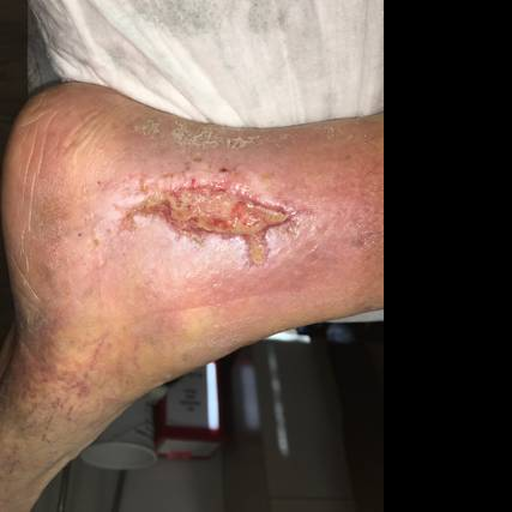

In [3]:
tsr_img = Image.open('../input/allulcus/allfoot/train/images/0014.png')
tsr_img

In [4]:
torch.manual_seed(0)
random.seed(0)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size = 16

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
transform2 = transforms.Compose([transforms.ToTensor(),])
transform_label = transforms.Compose([transforms.ToTensor(),])

transformToPIL = T.ToPILImage()

Using cuda device


In [6]:
class UlcerData(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        return (self.transforms(image),self.transform2(label))

In [7]:
class UlcerDataRotate(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        rotationParameter = T.RandomRotation.get_params((0,180))
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        image = self.transforms(image)
        label = self.transform2(label)
        image = T.functional.rotate(image,rotationParameter)
        label = T.functional.rotate(label,rotationParameter)
        return (image, label)

In [8]:
class UlcerDataFlip(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        horizontal = T.RandomHorizontalFlip(p=1)
        vertical = T.RandomVerticalFlip(p=1)
        image = self.transforms(image)
        label = self.transform2(label)
        if random.randint(1,2) == 1:
            image = horizontal(image)
            label = horizontal(label)
        else:
            image = vertical(image)
            label = vertical(label)
        return (image, label)

In [9]:
class UlcerDataShear(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        shearP = random.randint(-30,30)
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        image = self.transforms(image)
        label = self.transform2(label)
        image = T.functional.affine(image, 0, (0, 0), 1, shearP)
        label = T.functional.affine(label, 0, (0, 0), 1, shearP)
        return (image, label)

In [10]:
#Augmentations

transform_blur = transforms.Compose([transforms.ToTensor(),T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform_bright = transforms.Compose([transforms.ToTensor(),T.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



dataset = UlcerData("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform,transform2)
dataset_blur = UlcerData("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform_blur,transform2)
dataset_rotation = UlcerDataRotate("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform,transform2)
dataset_flip = UlcerDataFlip("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform,transform2)
dataset_shear = UlcerDataShear("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform,transform2)
#dataset_bright = UlcerData("../input/ulcuss/data/train/images","../input/ulcuss/data/train/labels",transform_bright,transform2)


valid_dataset = UlcerData("../input/ulcuss/data/validation/images","../input/ulcuss/data/validation/labels",transform,transform2)
a = torch.utils.data.ConcatDataset([dataset,dataset_rotation,dataset_flip,dataset_shear])
print(len(a))

3164


3164


In [12]:
valid_loader = DataLoader(valid_dataset,batch_size=1,shuffle = False)

In [13]:
train_loader = DataLoader(a,batch_size=batch_size,shuffle = True)
valid_loader = DataLoader(valid_dataset,batch_size=1,shuffle = False)
valid_loader2 = DataLoader(valid_dataset2,batch_size=1,shuffle = True)
len(train_loader)

198

In [14]:
tsr_img = Image.open('../input/ulcuss/data/train/images/0035.png')
trafo = transforms.ToTensor()

tsr = trafo(tsr_img)
train_mean = tsr.reshape(3,-1).mean(axis=1)
train_std = tsr.reshape(3,-1).std(axis=1)
print(train_mean)
train_std

tensor([0.4764, 0.4343, 0.4178])


tensor([0.3672, 0.3568, 0.3508])

In [15]:
img, mask = dataset[5]
img.shape 
mask.shape

torch.Size([1, 512, 512])

In [16]:
encoder = 'resnet34'
encoder_weights = 'imagenet'
ACTIVATION = 'softmax'
aux_params ={
    'activation':'sigmoid',
    'classes':1
}
#model

model = smp.Unet(
    encoder_name=encoder, 
    encoder_weights=encoder_weights, 
    classes=1,
    encoder_depth=4,
    decoder_channels=(256, 128, 64, 32),
    #activation='softmax',
    in_channels=3,
    #aux_params=aux_params
)          

#model.segmentation_head[2] = nn.Softmax()

#model.parameters

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [17]:
"""model.segmentation_head[2] = nn.ReLU()

model.parameters"""

'model.segmentation_head[2] = nn.ReLU()\n\nmodel.parameters'

In [18]:
lossF = nn.BCEWithLogitsLoss() #smp.losses.DiceLoss("binary")  
#metrics = [smp.utils.metrics.IoU(threshold=0.5),]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [19]:
model.to(device)
accuracy = []
lossL = []
diceL = []
for epoch in range(80):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader): #for i, (data, valid) in enumerate(zip(train_loader,valid_loader)):
        # get the inputs; data is a list of [inputs, labels]
        saveloss = 0
        savedice = 0
        inputs, labels = data[0].to(device), data[1].to(device)
        #val_input, val_label = valid[0].to(device), valid[1].to(device)
        # zero the parameter gradients\
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = lossF(outputs, labels)
        
        loss.backward()
        optimizer.step()
               
        #print(torch.max(outputs))
        #print(torch.min(outputs))
        """
        with torch.no_grad():
            val_prediction = model(val_input)
            val_loss = lossF(val_prediction, val_label)
            assert val_loss.requires_grad == False
        tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, val_label.long(), mode='binary', threshold=0.5)
        """      
        tp, fp, fn, tn = smp.metrics.get_stats(outputs, labels.long(), mode='binary', threshold=0.5)
        tp = tp.sum().item()
        fp = fp.sum().item()
        fn = fn.sum().item()
        tn = tn.sum().item()
        
        
        dices = (2*tp)/(2*tp+fp+fn)
        
        saveloss = loss.item()
        savedice = dices
        
            
        print(f"Epoch {epoch} i {i}, Training loss {loss.item():.4f}," f" Validation loss " f" Dice: {(2*tp)/(2*tp+fp+fn)}")
    #lossL.append(saveloss)
    #diceL.append(savedice)
print('Finished Training')
torch.save(model, './best_clean.pth')

Epoch 0 i 0, Training loss 0.5435, Validation loss  Dice: 0.03094133492966178
Epoch 0 i 1, Training loss 0.4652, Validation loss  Dice: 0.057961318355616465
Epoch 0 i 2, Training loss 0.4148, Validation loss  Dice: 0.05705811941788506
Epoch 0 i 3, Training loss 0.3229, Validation loss  Dice: 0.5625227269421536


KeyboardInterrupt: 

In [ ]:
#dice on validation ohne leere masken
model.eval()

allTP = 0
allFP = 0
allFN = 0
allTN = 0
maxx = 0
minn = 0
for i, data in enumerate(valid_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_prediction = model(inputs)
            tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, labels.long(), mode='binary', threshold=0.5)
        allTP += tp.sum().item()
        allFP += fp.sum().item()
        allFN += fn.sum().item()
        allTN += tn.sum().item()
        au = (2*tp)/(2*tp+fp+fn)
        if i==0 or (minn > au and au > 0.01):
            minn = au
        if maxx < au:
            maxx = au
        
        
print(f" Dice: {(2*allTP)/(2*allTP+allFP+allFN)}")
print(f"min {minn.item()}")
print(f"max {maxx.item()}")
iou = allTP/(allTP+allFP+allFN)
print(iou)
#0.88495 - 0.0.9108408776120601 - 0.914716125764638 (50 epochs) - 0.9235427361794043 (80 epochs) bce
#0.912688919617835 Dice loss 120 epochs
#0.921412496742761 4 schichten

In [ ]:

allTP = 0
allFP = 0
allFN = 0
allTN = 0
maxx = 0
minn = 0
for i, data in enumerate(valid_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_prediction = model(inputs)
            tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, labels.long(), mode='binary', threshold=0.5)
        allTP += tp.sum().item()
        allFP += fp.sum().item()
        allFN += fn.sum().item()
        allTN += tn.sum().item()
        au = (2*tp)/(2*tp+fp+fn)
        if i==0 or (minn > au and au > 0.01):
            minn = au
        if maxx < au:
            maxx = au
        
        
print(f" Dice: {(2*allTP)/(2*allTP+allFP+allFN)}")
print(f"min {minn.item()}")
print(f"max {maxx.item()}")
iou = allTP/(allTP+allFP+allFN)
print(iou)

In [ ]:
#dice on dataset

main = DataLoader(dataset,batch_size=batch_size,shuffle = True)
allTP = 0
allFP = 0
allFN = 0
allTN = 0
for i, data in enumerate(main):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_prediction = model(inputs)
            tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, labels.long(), mode='binary', threshold=0.5)
        
        allTP += tp.sum().item()
        allFP += fp.sum().item()
        allFN += fn.sum().item()
        allTN += tn.sum().item()
        #print(allTP)
        
        
print(f" Dice: {(2*allTP)/(2*allTP+allFP+allFN)}")
iou2 = allTP/(allTP+allFP+allFN)
print(iou2)
#0.9004
#0.9793600239993301

In [ ]:
m = nn.ReLU()
image, mask = dataset[4]
img = transformToPIL(image)
image = image.unsqueeze(0)
mask = transformToPIL(mask)
pre_mask = model(image.to('cuda'))
pre_mask = m(pre_mask)
#print(pre_mask)
#plt.imshow(pre_mask.to('cpu').squeeze().detach().numpy())

In [20]:
model = torch.load('../input/goodaa/model.pth')
showall = [1,2,3,4,5]

[16, 17, 18, 19, 20]
dice: 0.9762119843420657
Jaccard: 0.9535294117647058

dice: 0.6153477218225419
Jaccard: 0.4444059577416003

dice: 0.9517601043024772
Jaccard: 0.9079601990049752

dice: 0.7391638165701123
Jaccard: 0.5862488928255093

dice: 0.8591789310611929
Jaccard: 0.7531233025529603



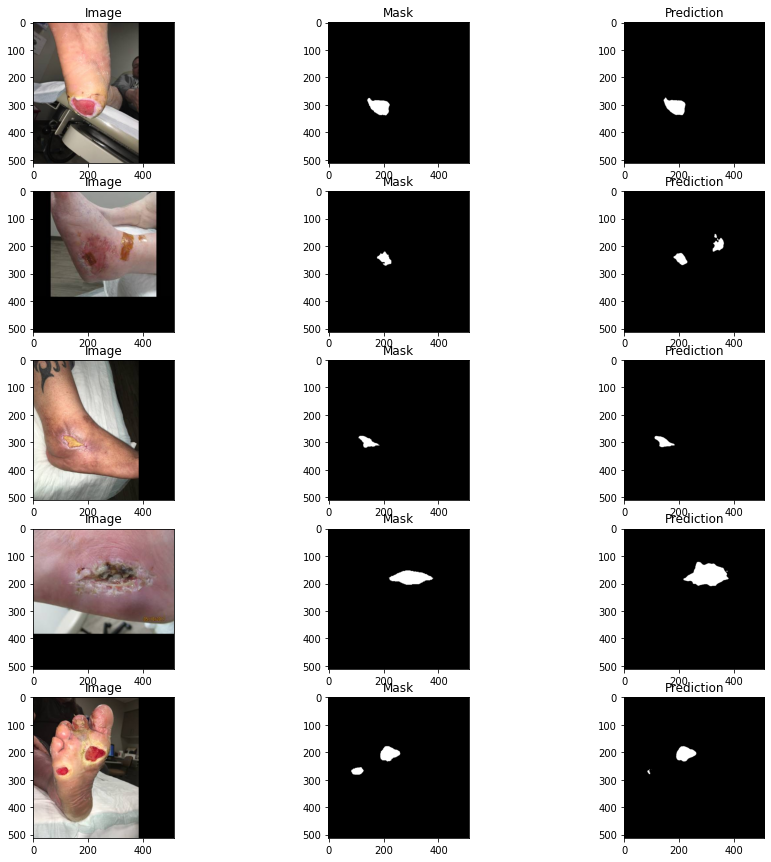

In [23]:
transformToPIL = transforms.ToPILImage()


transformT = T.ToTensor()
anzeige = UlcerData("../input/ulcuss/data/validation/images","../input/ulcuss/data/validation/labels",transformT,transform2)

showall = [x+5 for x in showall]
print(showall)
fig, ax = plt.subplots(nrows=5, ncols=3,figsize=(15, 15))
for i in range(0,5): #Number of example
    #a = np.random.randint(1,100)
    #print(a)
    a = showall[i]
    image, mask = valid_dataset[a]
    anzeig, _ = anzeige[a]
    anzeig = transformToPIL(anzeig)
    img = transformToPIL(image)
    image = image.unsqueeze(0)
    pre_mask = model(image.to('cuda'))
    tp, fp, fn, tn = smp.metrics.get_stats(pre_mask.to('cpu').squeeze(), mask.long().squeeze(), mode='binary', threshold=0.5)
    tp = tp.sum().item()
    fp = fp.sum().item()
    fn = fn.sum().item()
    tn = tn.sum().item()
    print(f'dice: {(2*tp)/((2*tp)+fn+fp) }')
    print(f'Jaccard: {tp/(tp+fp+fn)}')
    print()
    pre_mask = pre_mask.squeeze()
    pre_mask = (pre_mask>0.5).float()
    pre = transformToPIL(pre_mask)
    ax[i,0].imshow(anzeig)
    mask = transformToPIL(mask)
    ax[i,1].imshow(mask,cmap='gray')
    #print(pre_mask.detach())
    ax[i,2].imshow(pre_mask.cpu().detach(),cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].set_title('Mask')
    ax[i,2].set_title('Prediction')
plt.show()


#gute > 95 dice - 93 18 56 88 98 1 91 (eine instanz)


#gute > 90 dice - 93 18 (zwei)


#instanz vorhergesagt allerdings wo keine ist 2 10 82 17 79


# schlecht < 60 dice   40  14 55  53  27  53

# 0 dice 58 66



# 50 - 55

# 105 - 110

# 85